In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context("notebook")
plt.style.use('dark_background')
plt.rcParams["font.size"] = 18
np.random.seed(123)

In [4]:
df = pd.read_csv('./data/ch6_2.csv', header=None)
df.columns = ['data']

In [5]:
df.head()

,data
0,145.55
1,145.41
2,144.26
3,145.05
4,145.84


/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


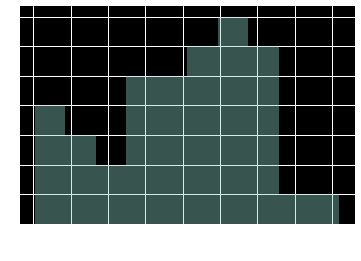

In [6]:
sns.distplot(df['data'], kde=False, bins=10)

In [29]:
stan_model = """
    data{
        int N;
        real X[N];
    }
    
    parameters{
        real mu;
        real<lower=0> sigma;
    }
    
    transformed parameters{
        real<lower=0> sigmasq;
        sigmasq <- pow(sigma, 2);
    }
    
    model{
        for(n in 1:N){
            X[n] ~ normal(mu, sigma);
        }
    }
    
    generated quantities{
        real<lower=0, upper=1> var_over1;
        real<lower=0, upper=1> var_over2;
        
        var_over1 <- step(sigmasq - 0.10);
        var_over2 <- step(sigmasq - 0.15);
    }
"""

In [30]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_717cac8a483b5d241d5c209eaec44649 NOW.


In [31]:
stan_data = {"N": df.shape[0], "X": df['data']}

In [32]:
fit = sm.sampling(data=stan_data, iter=11000, warmup=1000, chains=3, seed=1234)

/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [33]:
fit

Inference for Stan model: anon_model_717cac8a483b5d241d5c209eaec44649.
3 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=30000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu        144.99  4.7e-4   0.07 144.86 144.95 144.99 145.03 145.12  19173    1.0
sigma       0.41  3.6e-4   0.05   0.33   0.38   0.41   0.44   0.52  18433    1.0
sigmasq     0.17  3.1e-4   0.04   0.11   0.14   0.16   0.19   0.27  17839    1.0
var_over1   0.99  7.0e-4    0.1    1.0    1.0    1.0    1.0    1.0  20536    1.0
var_over2   0.66  3.1e-3   0.47    0.0    0.0    1.0    1.0    1.0  22846    1.0
lp__       15.53  9.8e-3   1.03  12.73  15.14  15.84  16.26  16.53  11008    1.0

Samples were drawn using NUTS at Sat Aug 11 22:58:06 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [34]:
la = fit.extract(permuted=True) # サンプル列
names = fit.model_pars #パラメーター名

/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


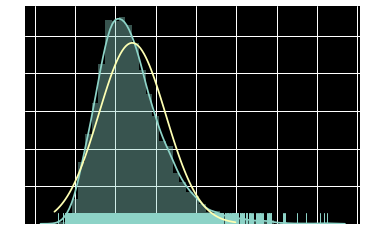

In [37]:
from scipy.stats import norm, gamma
u = la['sigmasq'].mean()
s = la['sigmasq'].std()
sns.distplot(la['sigmasq'][:5000], kde=True,rug=True, norm_hist=False, bins=40)
x = np.linspace(norm.ppf(0.01, loc=u, scale=s), norm.ppf(0.999, loc=u, scale=s), 100)
plt.plot(x, norm.pdf(x=x, loc=u, scale=s))